<center>
    <h1>
        Covid-19 Spread and Conatainment Measures
    </h1>
</center>

Since this is the last project in the nanodegree and because of the Covid-19 pandemic, I find this project an opportunity to learn to work on a project that is very relevant to the current time. Many people are tryinng to understand and visualize such data and this notebook is my own contribution to the society. The data was collected until March,27 2020.

In [631]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", font_scale=1.2)

## Data Gathering and Wrangling

Data was collected from different sources. My main source to search for data was: https://www.kaggle.com

### Datasets included:

- **[Covid Containment Dataset][1]:** The dataset was collected from http://epidemicforecasting.org/containment. The description included:
>>Each measure in the database has entries on:
  - Country (and state for the US)
  - Textual description of the measure
  - Start date of measure
  - End date (if available)
  - URL to source of more information
  - Systematic keyword labels (e.g. "travel ban" or "hygiene enforcement")

- **[Covid-19 Dataset][2]:** Collected from the [World Health Organisation][3]. Content includes:
>> This dataset has daily level information on the number of affected cases, deaths and recovery from 2019 novel coronavirus. Please note that this is a time series data and so the number of cases on any given day is the cumulative number.
  - Sno - Serial number
  - ObservationDate - Date of the observation in MM/DD/YYYY
  - Province/State - Province or state of the observation (Could be empty when missing)
  - Country/Region - Country of observation
  - Last Update - Time in UTC at which the row is updated for the given province or country. (Not standardised and so please clean before using it)
  - Confirmed - Cumulative number of confirmed cases till that date
  - Deaths - Cumulative number of of deaths till that date
  - Recovered - Cumulative number of recovered cases till that date
- **[Country population and other data][5]:** Collected from a kaggle dataset. Only specific columns like population and median age are useful to compare countrie.
  
- **Data Specific to Country (Lebanon):** Since I am from Lebanon, I am interested in how this country compares to other countries. Most of the required data is available in the 2nd database. However, additional data was obtained manually from local and [government websites][4].
[1]:https://www.kaggle.com/paultimothymooney/covid19-containment-and-mitigation-measures
[2]:https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset
[3]:https://www.who.int/emergencies/diseases/novel-coronavirus-2019
[4]:http://corona.ministryinfo.gov.lb/
[5]:https://www.kaggle.com/tanuprabhu/population-by-country-2020

In [632]:
containment = pd.read_csv('./datasources/covid_containment.csv')
containment.head()
rename_col  = {'Country': 'country',
               'Date Start': 'date', 'Keywords':'keywords'}
cols_to_keep = list(rename_col.values())
containment = containment.rename(columns=rename_col)
containment = containment.drop(containment.columns.difference(cols_to_keep),axis=1)
containment['date'] = pd.to_datetime(containment['date'])
containment.dropna(subset=['country','date','keywords'],inplace=True)
containment.loc[containment.country.str.contains('US:'),'country'] = 'United States' #replace all states with just US
containment.head()

,country,date,keywords
0,Austria,2020-03-16,university closure
1,Germany,2020-02-01,"international traveller screening, traveller q..."
2,United Kingdom,2020-03-20,"nursery schools closure, school closure, unive..."
3,United Kingdom,2020-03-16,"14 days, contact isolation"
4,United Kingdom,2020-03-16,isolation advice to elderly


In [633]:
# add data for lebanon
leb_cont = pd.read_csv('./datasources/lebanon_containment.csv')
leb_cont['date']= pd.to_datetime(leb_cont['date'])
containment = pd.concat([containment,leb_cont],ignore_index=True)

In [634]:
containment.query('country == "Lebanon"').head()

,country,date,keywords
992,Lebanon,2020-02-21,first case
993,Lebanon,2020-02-29,"school closure, university closure"
994,Lebanon,2020-03-06,"business suspension, restaurant limitations"
995,Lebanon,2020-03-10,first death
996,Lebanon,2020-03-11,first recovery


In [635]:
covid= pd.read_csv('./datasources/covid_19_data.csv')
cols_rename = {'Country/Region':'country','ObservationDate':'date','Confirmed':'confirmed',
               'Deaths':'deaths','Recovered':'recovered'}
covid.rename(columns=cols_rename,inplace=True)
cols_keep = ['date','country','confirmed','deaths','recovered']
covid.drop(covid.columns.difference(cols_keep),axis=1,inplace=True)
covid.head()

,date,country,confirmed,deaths,recovered
0,01/22/2020,Mainland China,1.0,0.0,0.0
1,01/22/2020,Mainland China,14.0,0.0,0.0
2,01/22/2020,Mainland China,6.0,0.0,0.0
3,01/22/2020,Mainland China,1.0,0.0,0.0
4,01/22/2020,Mainland China,0.0,0.0,0.0


In [636]:
pop = pd.read_csv('./datasources/population_by_country_2020.csv')
col_rename = {'Country (or dependency)': 'country','Population (2020)':'population',
              'Density (P/Km²)':'density','Med. Age':'median_age','Urban Pop %':'urban_pop'}
pop.rename(columns=col_rename,inplace=True)
cols_keep = col_rename.values()
pop.drop(pop.columns.difference(cols_keep),axis=1,inplace=True)
pop.head()

,country,population,density,median_age,urban_pop
0,China,1439323776,153,38,61%
1,India,1380004385,464,28,35%
2,United States,331002651,36,38,83%
3,Indonesia,273523615,151,30,56%
4,Pakistan,220892340,287,23,35%


In [637]:
# rename some countries for merging
containment_country_names= {'Czechia':'Czech Republic','Kosovo':'Serbia','Vatican City': 'Italy','Macau':'Macao',
                            'Guernsey': 'Others','Jersey': 'Others'}
containment= containment.replace({'country':containment_country_names})
containment = containment.query('country != "Others"') # removing 'Others' as country

In [638]:
# merging containment and covid data but first we need to rename some countries
# long list of names since I collected data from 2 different sources
# found this list by doing a left merge then checking the nan values
country_map= {'Mainland China': 'China','US': 'United States','UK':'United Kingdom',
              'Republic of Ireland':'Ireland','North Ireland':'Ireland', 'The Bahamas': 'Bahamas',
              'Bahamas, The': 'Bahamas', 'Burma': 'Myanmar','Cape Verde': 'Cabo Verde','Macau':'Macao',
              'Ivory Coast': 'Côte d\'Ivoire', 'occupied Palestinian territory': 'Palestine',
              'West Bank and Gaza':'Palestine','Republic of the Congo':'Congo',
              'Saint Vincent and the Grenadines':'St. Vincent & Grenadines','The Gambia':'Gambia',
              'Gambia, The':'Gambia','Saint Kitts and Nevis': 'Saint Pierre & Miquelon',
              'Reunion': 'France','Kosovo':'Serbia','Curacao':'Curaçao', 'East Timor':'Timor-Leste',
              'Vatican City': 'Italy','Faroe Islands':'Faeroe Islands','Guernsey': 'Others',
              'Diamond Princess': 'Others','Jersey': 'Others','North Macedonia':'Macedonia'
             }
covid.loc[covid.country.str.contains('Brazzaville'),'country'] = 'Congo' # dataset contains different city names for congo
covid.loc[covid.country.str.contains('Kinshasa'),'country'] = 'Congo'
covid.loc[covid.country.str.contains('\)'),'country'] = 'St. Martin' # just for proper formatting
covid.country = covid.country.str.strip() #removing whitespace so it doesnt cause problems with merge
covid= covid.replace({'country':country_map}) # now replace all country names
covid = covid.groupby(['country','date'])[['confirmed','deaths','recovered']].sum() # make sure we add the cases in all countries
covid = covid.reset_index()
covid['date'] = pd.to_datetime(covid['date'])
covid.head()

,country,date,confirmed,deaths,recovered
0,Afghanistan,2020-02-24,1.0,0.0,0.0
1,Afghanistan,2020-02-25,1.0,0.0,0.0
2,Afghanistan,2020-02-26,1.0,0.0,0.0
3,Afghanistan,2020-02-27,1.0,0.0,0.0
4,Afghanistan,2020-02-28,1.0,0.0,0.0


In [639]:
# fix some data for Lebanon
covid.loc[2389,'confirmed'] = 99
covid.loc[2390,'confirmed'] = 110 

In [640]:
# just make names easier to work with
pop = pop.replace({'country':{'Czech Republic (Czechia)': 'Czech Republic','State of Palestine': 'Palestine',
                             'Saint Martin':'St. Martin', 'North Macedonia': 'Macedonia'
                             }})
pop['urban_pop']= pop['urban_pop'].str.replace('%','')
pop['urban_pop'] = pd.to_numeric(pop['urban_pop'],errors='coerce') /100
pop['median_age'] = pd.to_numeric(pop['median_age'],errors='coerce').fillna(0).astype('int')
pop[pop.median_age == 0 ].head() # many missing values but thats fine

,country,population,density,median_age,urban_pop
201,Isle of Man,85033,149,0,0.53
202,Andorra,77265,164,0,0.88
203,Dominica,71986,96,0,0.74
204,Cayman Islands,65722,274,0,0.97
205,Bermuda,62278,1246,0,0.97


In [641]:
countries = pd.merge(covid,pop,how='left',on='country') # doing a left merge to check that no country name is different
countries[countries.population.isna()].country.value_counts() # one last check

Others    49
Name: country, dtype: int64

In [642]:
df = pd.merge(containment,countries,how='outer',on=['country','date'])

In [643]:
# concat duplicate values
# idea from https://stackoverflow.com/a/53463151/4145941
index_cols = df.columns.tolist()
index_cols.remove("keywords") 
df = df.groupby(index_cols)["keywords"].apply(list)
df = df.reset_index()
df.keywords = [','.join(map(str, l)) for l in df['keywords']]

In [644]:
df[df.confirmed.isna()]

,country,date,confirmed,deaths,recovered,population,density,median_age,urban_pop,keywords


In [645]:
# finally here is our data
df.head()

,country,date,confirmed,deaths,recovered,population,density,median_age,urban_pop,keywords
0,Afghanistan,2020-02-24,1.0,0.0,0.0,38928346.0,60.0,18.0,0.25,nan
1,Afghanistan,2020-02-25,1.0,0.0,0.0,38928346.0,60.0,18.0,0.25,nan
2,Afghanistan,2020-02-26,1.0,0.0,0.0,38928346.0,60.0,18.0,0.25,nan
3,Afghanistan,2020-02-27,1.0,0.0,0.0,38928346.0,60.0,18.0,0.25,nan
4,Afghanistan,2020-02-28,1.0,0.0,0.0,38928346.0,60.0,18.0,0.25,nan


## Exploratory Data Analysis

After Collecting the data and removing unnecessary columns, it is time to start exploring. 
    
### Structure of the Dataset

In [646]:
df.shape

(4365, 10)

The dataset contains 10 columns and 4251 rows. Here is a quick summary of the columns:
- country: name of the country
- date: the date at which the entry was observed.
- confirmed: confirmed cases of Covid-19 in the country (cumulative value)
- deaths: confirmed cases of death due to Covid-19 (cumulative value)
- recovered: recovered cases from Covid-19 (cumulative value)
- population: population of the country
- density: density calculated as Person/Km2
- median_age: median age of people in the country
- urban_pop: Urban population (given as percent value)
- keywords: some of the measures taken to limit the spread of the infection by each country.

In addition, here is an overview of the column types and summary of their values:

In [647]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4365 entries, 0 to 4364
Data columns (total 10 columns):
country       4365 non-null object
date          4365 non-null datetime64[ns]
confirmed     4365 non-null float64
deaths        4365 non-null float64
recovered     4365 non-null float64
population    4365 non-null float64
density       4365 non-null float64
median_age    4365 non-null float64
urban_pop     4365 non-null float64
keywords      4365 non-null object
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 341.1+ KB


In [648]:
df.describe()

,confirmed,deaths,recovered,population,density,median_age,urban_pop
count,4365.000000,4365.000000,4365.000000,4.365000e+03,4365.000000,4365.000000,4365.000000
mean,1726.013746,66.284994,560.079496,7.848511e+07,193.157617,33.036884,0.654962
std,9387.440359,449.732124,5231.324044,2.356623e+08,289.573740,10.022032,0.216216
min,0.000000,0.000000,0.000000,5.794000e+03,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,4.937786e+06,43.000000,27.000000,0.520000
50%,16.000000,0.000000,1.000000,1.671896e+07,103.000000,33.000000,0.700000
75%,128.000000,1.000000,5.000000,5.126918e+07,240.000000,42.000000,0.830000
max,101657.000000,9134.000000,74600.000000,1.439324e+09,2239.000000,48.000000,1.000000


### Main Feature of Interest

Like most researchers nowadays, I am interested in understanding more about the Covid-19. Our main focus is its spread and the effictiveness of measures taken to slow its progress. For that here are some main questions to be answered:

- Which countries are doing better than others and why ?
- What measures are the most effective against the spread of the virus?
- How do the death and recovery rates compare according to population, density and median age of a country?
- How does Lebanon compare to other countries regarding measures taken and spread of the virus ? 

### Features that Will Help in the Investigation

I have removed most of the columns that will not have any use. For that almost all of the columns in the above dataset are useful in answering the questions.

## Univariate Plots

In this section, we will take a look at individual variables and their distributions. The three main variables we should look at are 'confirmed', 'recovered' and 'deaths' since they relate directly to our interest. In addition, we will take a look at the 'keywords' variable to check the most common measures.

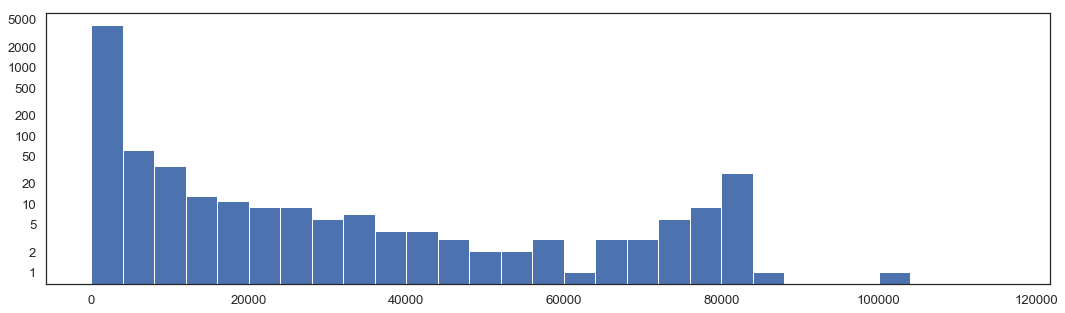

In [649]:
# plotting on a log scale because of the huge difference in the data
plt.figure(figsize=(18,5))
plt.hist(df.confirmed,log=True, bins=np.arange(0,120000,4000));
yticks = [1,2,5,10,20,50,100,200,500,1000,2000,5000]
plt.yticks(yticks,yticks);

The data we see is bimodal. Two peaks are very apparent: one is close to 0 and the other one is centered at 80000. Given that data is collected for about 3 months only, the 2 peaks explain the scary nature of the exponential spread of the virus: It doesn't take a long time for a country to go from very few cases to cases in thousands.

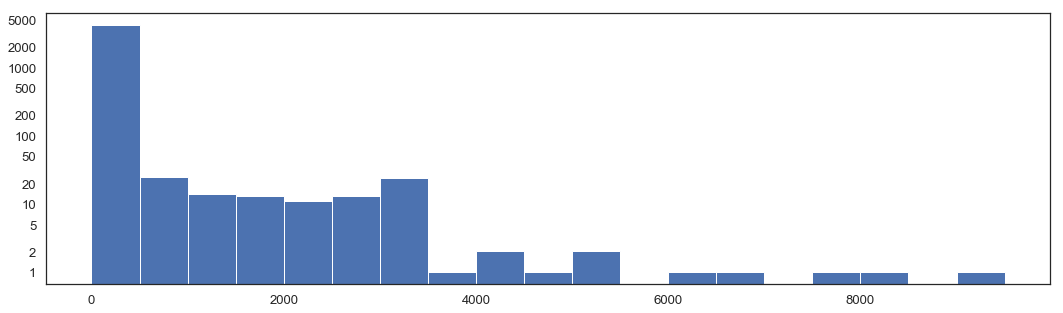

In [650]:
plt.figure(figsize=(18,5))
plt.hist(df.deaths,log=True, bins=np.arange(0,10000,500));
yticks = [1,2,5,10,20,50,100,200,500,1000,2000,5000]
plt.yticks(yticks,yticks);

Similar to the above case, the data is generally bimodal. However, it is more skewed to the right which is a good sign: the mortality rate is low in general. In addition, the data is more spread and there are many individual cases with high death rate: These are probably cases like Italy and the United States where the virus spread very fast.

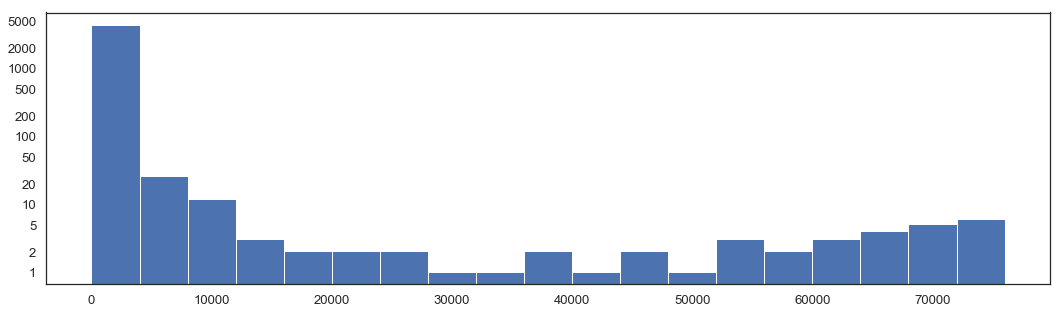

In [651]:
plt.figure(figsize=(18,5))
plt.hist(df.recovered,log=True, bins=np.arange(0,77000,4000));
yticks = [1,2,5,10,20,50,100,200,500,1000,2000,5000]
plt.yticks(yticks,yticks);

Here again, we see two distant peaks with one at the very beginning and one at the end. Data in both cases seem to be cut off suddenly. The 2 peaks probably match with the 2 peaks in the 'confirmed' variable. More infections = More recovery. 

Finally, if we look at all the three plots, we can see a common theme: many countries have a low amount of infections (between 0 and 1000) and if no measures are taken, the virus will spread quickly and become a high threat to the country.

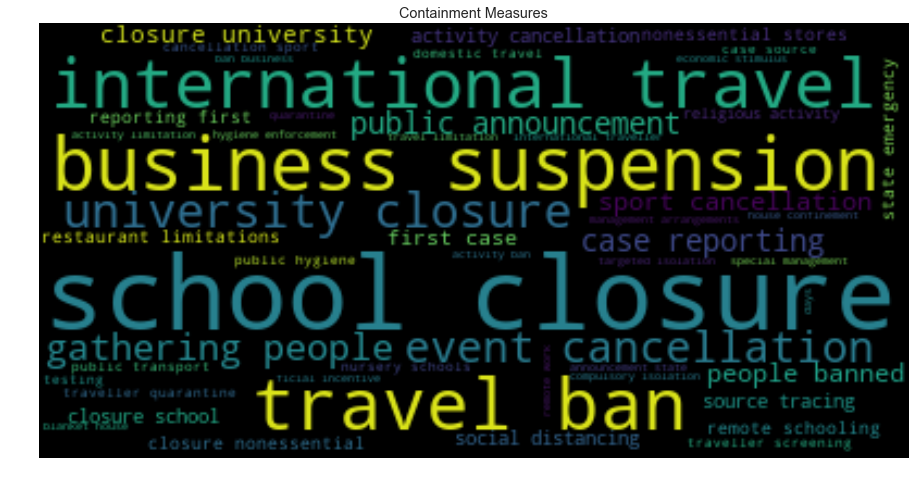

In [652]:
# in order for this to work we need to install an additional library
# !pip install wordcloud
# idea from https://www.datacamp.com/community/tutorials/wordcloud-python

from wordcloud import WordCloud
text = ' '.join(df.keywords).replace('nan','')
wordcloud = WordCloud(min_font_size= 5,max_font_size=100).generate(text)
plt.figure(figsize=[18,8])
plt.title('Containment Measures')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");
plt.show()

The word cloud gives the most common measures taken by countries to slow the spread of the disease. Most common measures include:
- Closing of public buildings (schools, universities)
- Banning travel
- canceling social events
- social distancing and banning the gathering of people

## Bivariate Plots

Now lets take a look at the relationship between pairs of data. One main plot to consider is the spread through time.

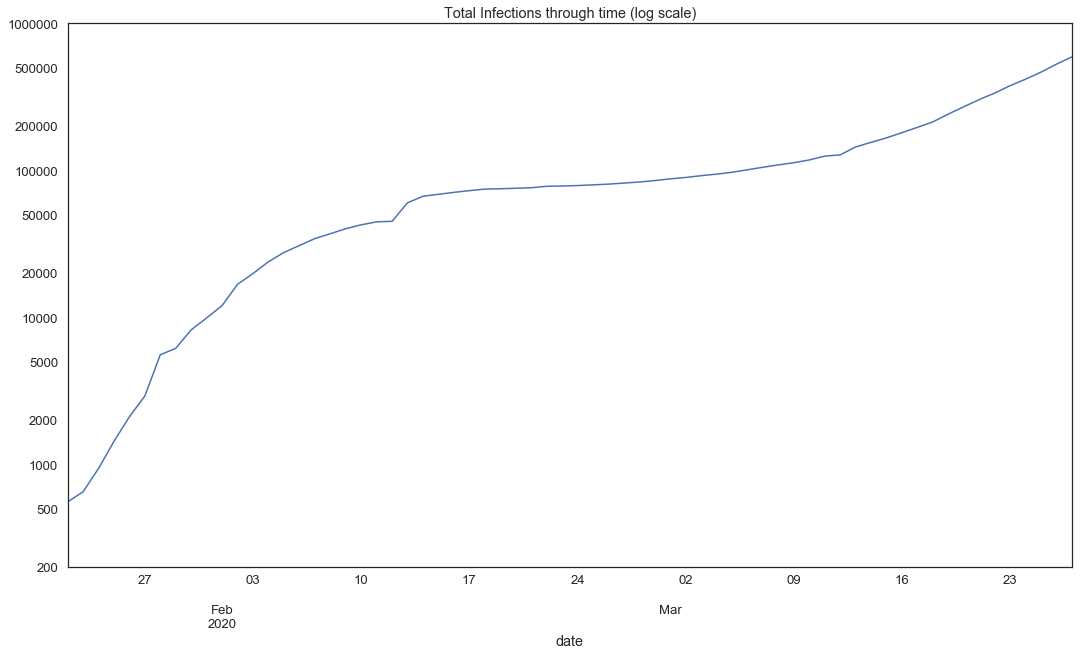

In [653]:
# increase in total confirmed cases
# again, using log scale because of the exponential growth
plt.figure(figsize=(18,10))
np.log10(df.groupby('date')['confirmed'].sum()).plot()
yticks = [200,500,1000,2000,5000,10000,20000,50000,100000,200000,500000,1000000]
plt.yticks(np.log10(yticks),yticks)
plt.title('Total Infections through time (log scale)');

In general, we would expect the infection to spread linearly on a log scale. This is not the case here, it seems that there is a certain time (during the period of discovery of the virus) where the infection rates increased much more greatly than we might expect. However, in the end the curve flattens out and is becoming linear as we expect. 

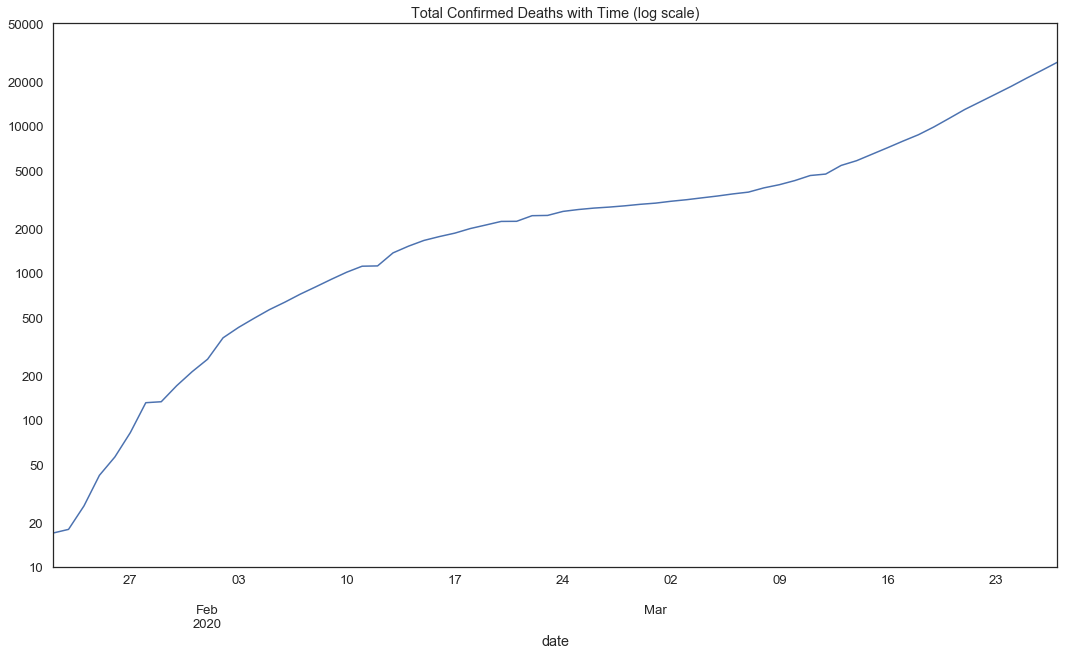

In [654]:
# similarly lets take a look at the other variables with time
plt.figure(figsize=(18,10))
np.log10(df.groupby('date')['deaths'].sum()).plot()
yticks = [10,20,50,100,200,500,1000,2000,5000,10000,20000,50000]
plt.yticks(np.log10(yticks),yticks);
plt.title('Total Confirmed Deaths with Time (log scale)');

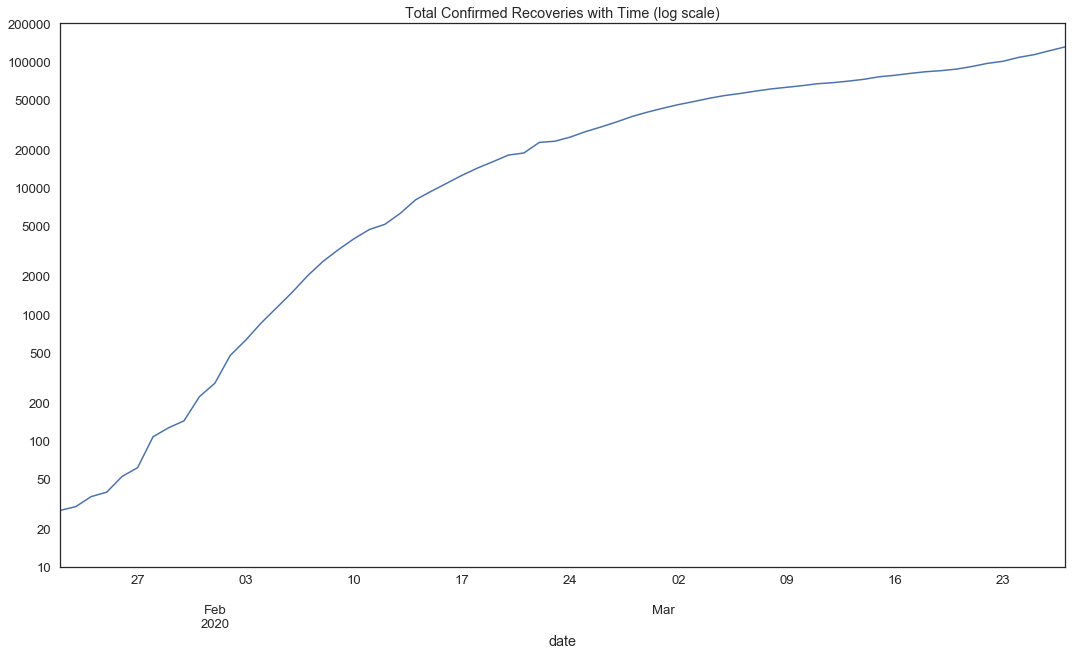

In [655]:
plt.figure(figsize=(18,10))
np.log10(df.groupby('date')['recovered'].sum()).plot()
yticks = [10,20,50,100,200,500,1000,2000,5000,10000,20000,50000,100000,200000]
plt.yticks(np.log10(yticks),yticks);
plt.title('Total Confirmed Recoveries with Time (log scale)');

Deaths and recoveries show a similar behavior to the confirmed cases. However, deaths are much quicker in adjusting and recoveries seem to take more time peak and readjust. This makes sense because recoveries can only happen after a period of time from infections.

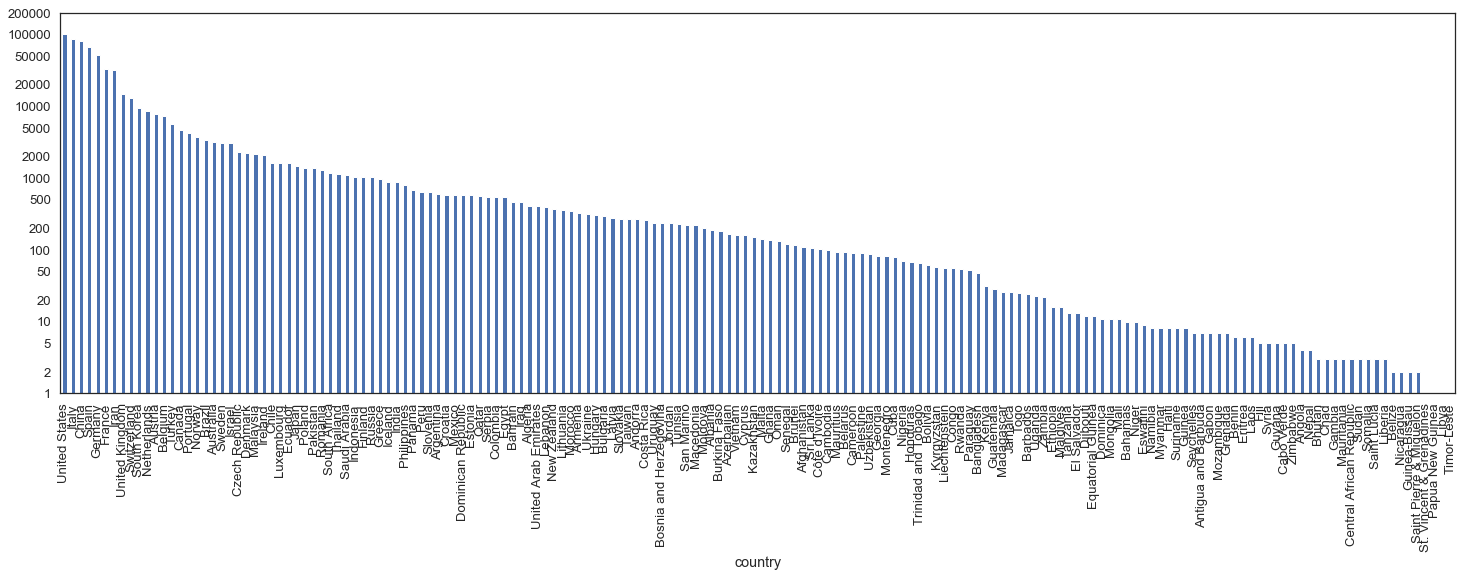

In [656]:
# confirmed cases across countries
data = df.query('date == "2020-03-27"') # pick the most recent date
data = np.log10(data.groupby('country')['confirmed'].sum().sort_values(ascending=False)) # sorting countries and using log scale
yticks= [1,2,5,10,20,50,100,200,500,1000,2000,5000,10000,20000,50000,100000,200000]
plt.figure(figsize=(25,7))
data.plot(kind='bar')
plt.yticks(np.log10(yticks),yticks);

We can see the nature of the total  distribution across countries. The data looks linear with some slight 'bumps' in certain regions. Again, a log scale is used to account for the huge difference in data and the exponential nature of the virus transmission.

The graph also show that the country with the most confirmed cases is the United States followed by Italy and China. 

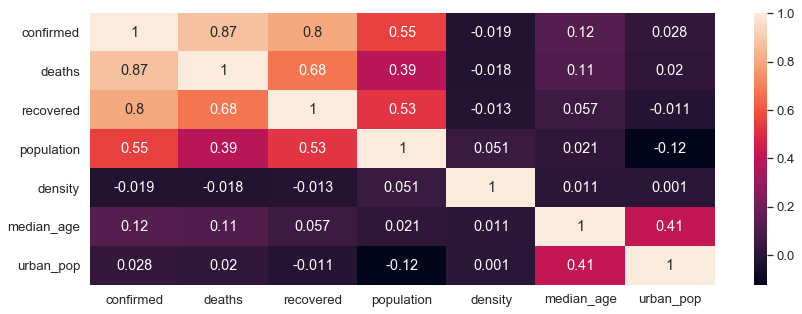

In [657]:
# now lets take a look at the correlation between all variables
plt.figure(figsize=(14,5))
sns.heatmap(df.corr(),annot = True);

This is a very interesting plot. What we are mostly interested in is the upper left (bright) rectangle. Here are the main observations:
- The number of confirmed infections is highly correlated with: the number of deaths,  the number of recoveries and the population of the country.
- The number of deaths is also correlated with the number of recovering cases but has a week correlation with the population.
- The median age, density, and percentage of urban population seem to have no effect on any of the cases.

The relation between the above variables is worth looking at more closely.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


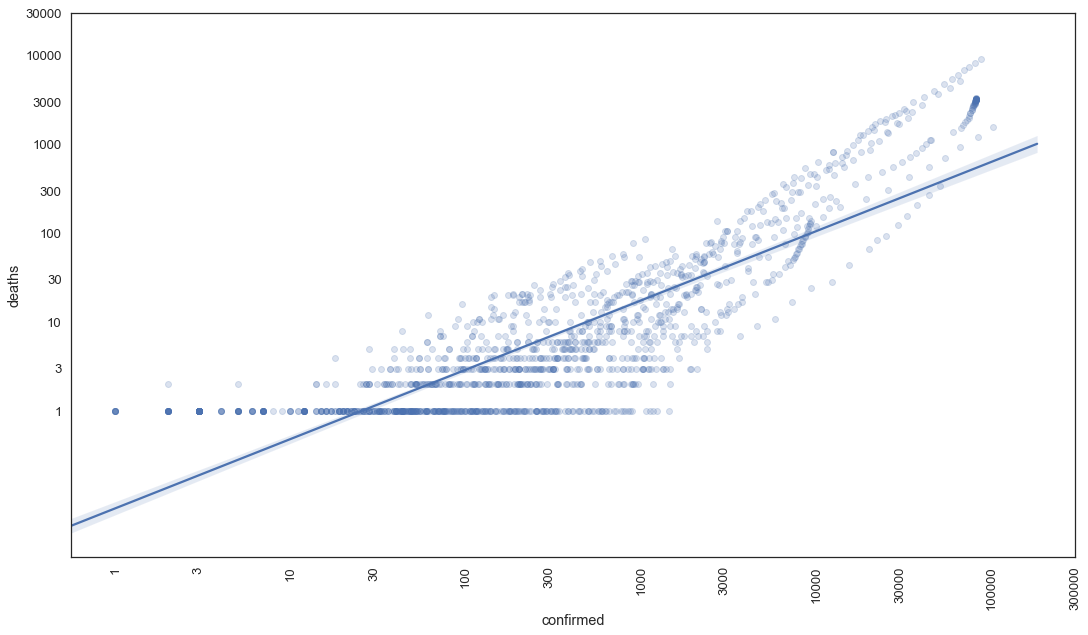

In [658]:
# lets first take a look at the relationship between confirmed cases and number of deaths
# lets also not forget to use a log scale for both values
# since some of these values are 0 we have to make sure to remove these values
df2 = df #.query('date == "2020-03-27"') # we can choose a single date to see the data more clearly
df2 = df2[(df2.confirmed != 0) & (df2.deaths != 0)]
x = np.log10(df2.confirmed)
y= np.log10(df2.deaths)
plt.figure(figsize=(18,10))
xticks = [1,3,10,30,100,300,1000,3000,10000,30000,100000,300000]
yticks= xticks[:-2]
sns.regplot(x,y,scatter_kws={'alpha':1/5});
plt.xticks(np.log10(xticks),xticks,rotation=90)
plt.yticks(np.log10(yticks),yticks);

We can see a clear trend here: with a low number of cases, the data is very scattered. It starts to converge slowly into a single line as the number of cases increase. The line has a slope of around 0.1 (which is close to the global mortality rate).

It is also clear that the regression line deviates from that line due to the high number of cases at 1.

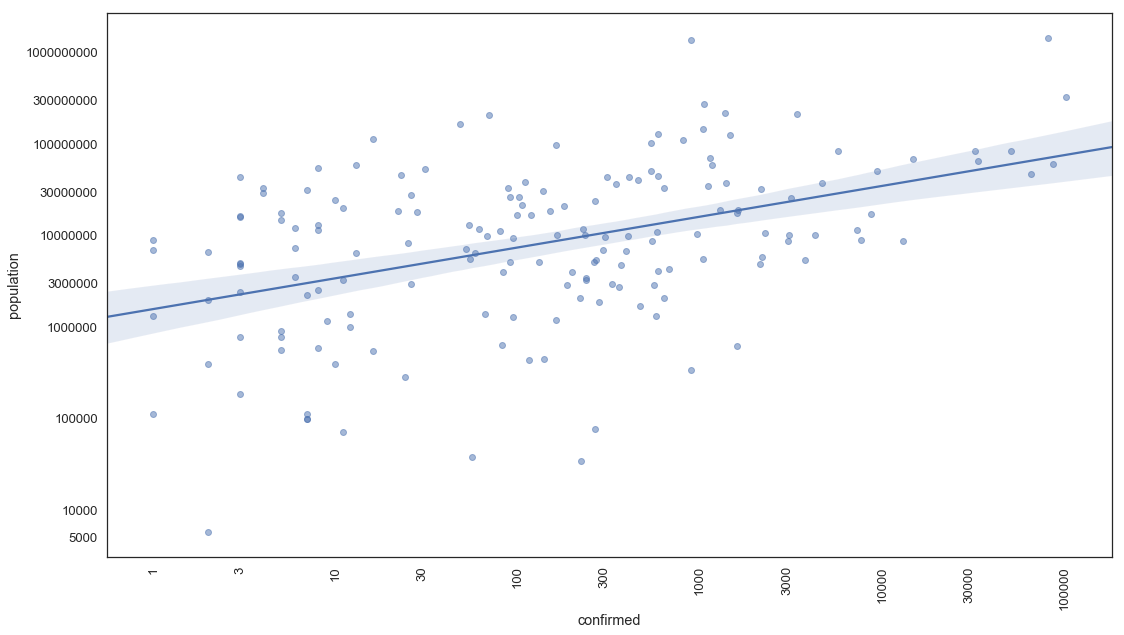

In [659]:
# Now lets look at the confirmed cases vs population
df2 = df.query("date == '2020-03-27'") # lets take a look at just 1 day to avoid duplicate values
df2 = df2[(df2.confirmed != 0) & (df2.population !=0)]
x = np.log10(df2.confirmed)
y = np.log10(df2.population)
plt.figure(figsize=(18,10))
xticks = [1,3,10,30,100,300,1000,3000,10000,30000,100000,300000]
plt.xticks(np.log10(xticks),xticks,rotation=90)
yticks = [5000,10000,100000,1000000,int(3e6),int(1e7),int(3e7),int(1e8),int(3e8),int(1e9),int(3e9)]
plt.yticks(np.log10(yticks),yticks)
sns.regplot(x,y,scatter_kws={'alpha':1/2});

The graph above suggests that there is no relation between the confirmed infection rates and the population of the country. This could be due to several reasons:
- Measures taken by countries to stop the infection
- Since we can check only 'confirmed' cases. The confirmed variable could be affected by the ability of a country to do tests.
- Some countries do not report the actual confirmed cases they have

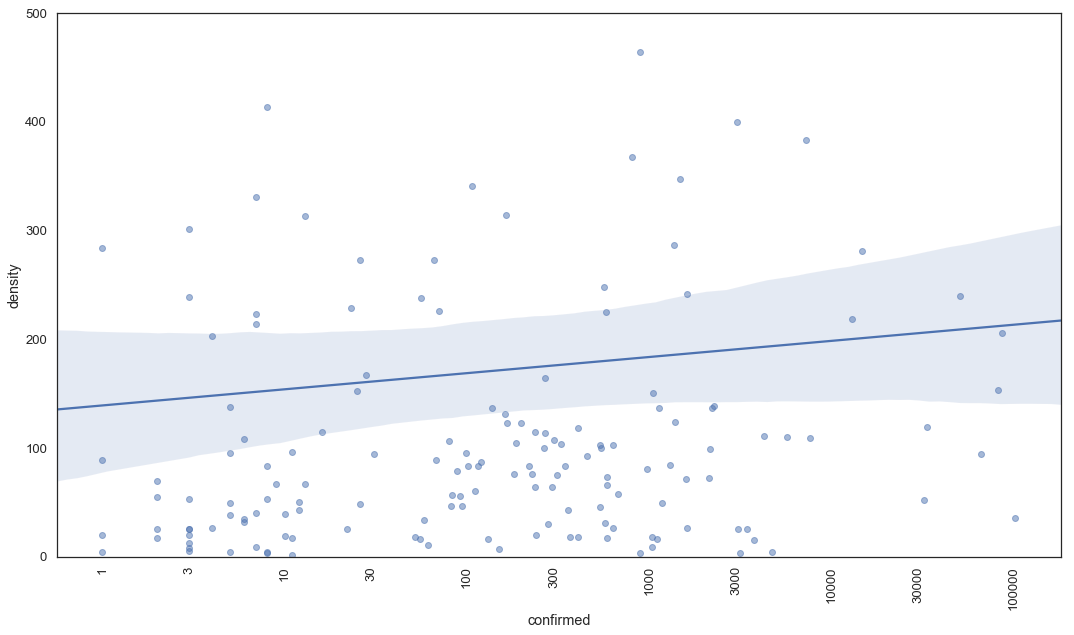

In [660]:
# Lets take a look to see if the density of a country is related
df2 = df.query("date == '2020-03-27'") # also last date so we can filter by country
df2 = df2[(df2.confirmed != 0) & (df2.density !=0)]
x = np.log10(df2.confirmed)
y = df2.density # no need to use log here
plt.figure(figsize=(18,10))
xticks = [1,3,10,30,100,300,1000,3000,10000,30000,100000,300000]
plt.xticks(np.log10(xticks),xticks,rotation=90) # same xticks as above
#yticks = [5000,10000,100000,1000000,int(3e6),int(1e7),int(3e7),int(1e8),int(3e8),int(1e9),int(3e9)]
#plt.yticks(np.log10(yticks),yticks)
plt.ylim(0,500) # zooming in
sns.regplot(x,y,scatter_kws={'alpha':1/2});

Again, no apparent relation is found between the confirmed cases and the density of a country. Although we could say that more dense countries are more scattered than the less dense ones.

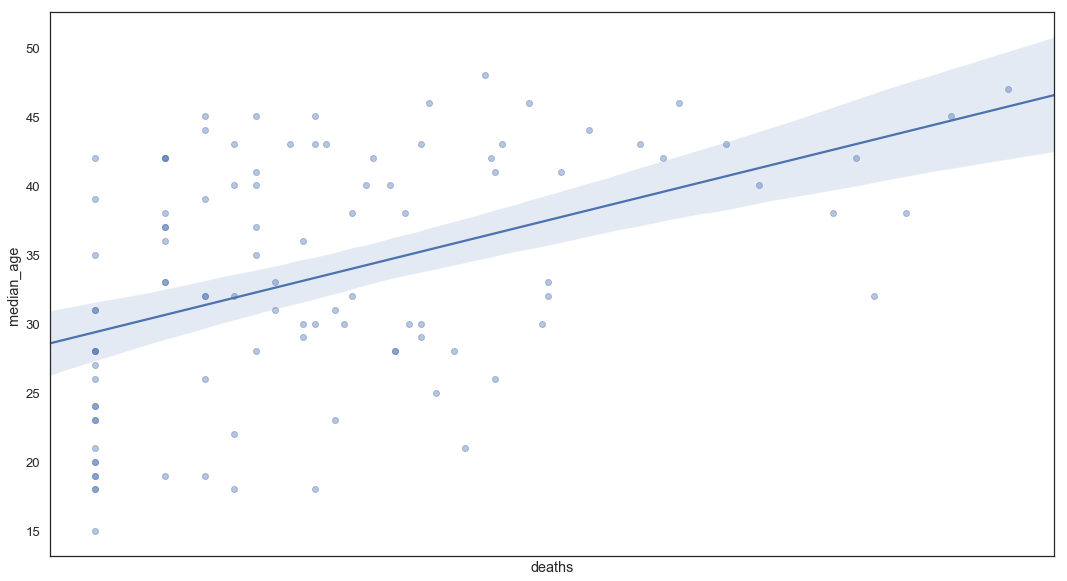

In [661]:
# Now we take a look at median age vs deaths
df2 = df.query("date == '2020-03-27'")
df2 = df2[(df2.deaths != 0) & (df2.median_age !=0)]
x = np.log10(df2.deaths)
y= df2.median_age
plt.figure(figsize=(18,10))
xticks = [0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,0.6]
plt.xticks(np.log10(xticks),xticks)
sns.regplot(x,y,scatter_kws={'alpha':0.4});

The data verifies what we know about the virus: it is generally more lethal to older people. However, no clear trend is observed.

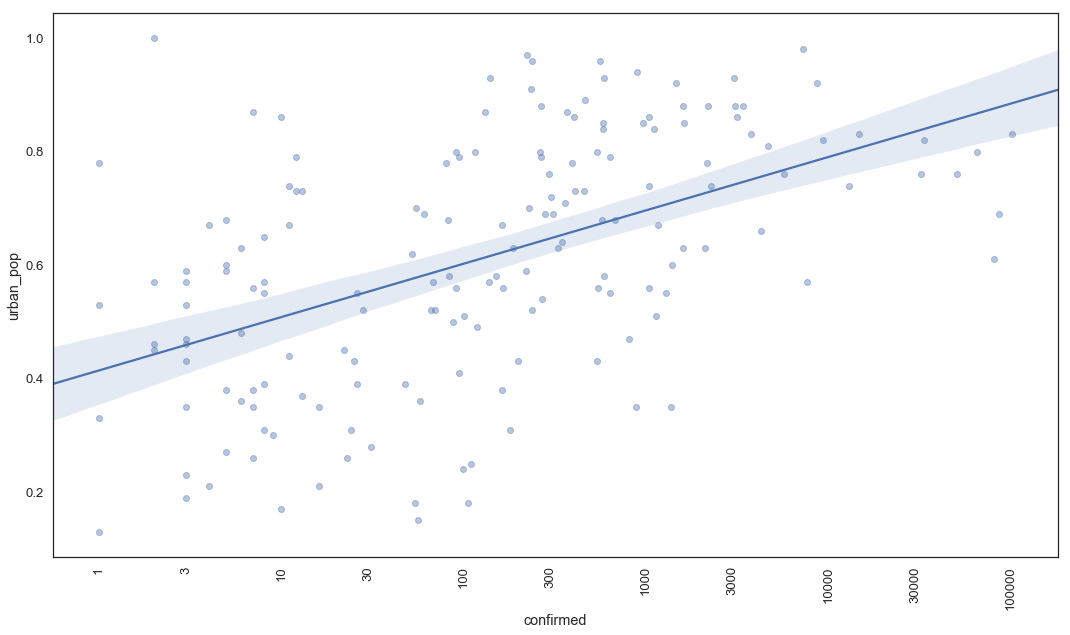

In [662]:
# one final thought: are people in the cities more suscptible to the virus
df2 = df.query("date == '2020-03-27'")
df2 = df2[(df2.confirmed != 0) & (df2.urban_pop !=0)]
x = np.log10(df2.confirmed)
y= df2.urban_pop
plt.figure(figsize=(18,10))
xticks = [1,3,10,30,100,300,1000,3000,10000,30000,100000,300000]
plt.xticks(np.log10(xticks),xticks,rotation=90)
sns.regplot(x,y,scatter_kws={'alpha':0.4});

Although the data is scattered and no clear line can be drawn, the trend of the data seems to be going upwards suggesting that cities can be a factor in spreading the virus (as expected).

## Multivariate Exploration

After looking through our variables, it is time to check how to combine them together to check for more useful results.

In the Bivariate Plots section, we looked at the spread of infection through time. This time however, we will take a look at the spread in a different way: we will compare the new cases vs total cases in a specific date and for each country (each country represents a dot). This was inspired by this [video][1].

In short, if we plot new cases vs total cases, we can tell which countries are doing better and which are doing worse. Ultimately, this could serve as a prediction for how well a country will do in the following days. In order to do that however, we will need to create a new variable called 'new_cases' which is the increase in the number of cases from the previous day.

[1]:https://youtu.be/54XLXg4fYsc

In [663]:
# add a new column called 'new cases'
# this will count the increase in new cases (per day) instead of the total cumulative value
df2 = df.groupby(['country','date'])['confirmed'].sum().diff()
df2 = df2.reset_index()
df2.loc[df2.confirmed<0,'confirmed'] =0 
df2= df2.fillna(0)
df['new_cases'] = df2['confirmed']

After creating the variable, we can check the performance of each country and try to predict future performance. For that, I have selected 2 dates to compare: 'Mar,27' (most recent update of data I have) and 'Mar,13' (around 14 days before 27 march). 

In addition, since there are many different countries, I have chosen to highlight only few of them for comparison purposes.

In [664]:
def plot_on_date(interest_date,interest_countries):
    '''
    interest_date: the date we are interested in (yyyy-mm-dd)
    interest_countries: a list of countries we are interested in.
    '''
    df2 = df.query(('date == @interest_date'))
    df2 = df2[(df2.confirmed != 0) & (df2.new_cases !=0)]
    x = np.log10(df2.confirmed)
    y = np.log10(df2.new_cases)
    xticks = [1,3,10,30,100,300,1000,3000,10000,30000,100000,300000]
    plt.xticks(np.log10(xticks),xticks)
    yticks =  [1,3,10,30,100,300,1000,3000,10000,30000]
    plt.yticks(np.log10(yticks),yticks)
    ax = sns.regplot(x,y,scatter_kws={'alpha':0.5},fit_reg=False);
    plt.title(interest_date)
    for i in interest_countries:
        subset = df2.query('country == @i')
        x = np.log10(subset.confirmed) - 0.1
        y = np.log10(subset.new_cases) + 0.1
        ax.text(x,y,i)

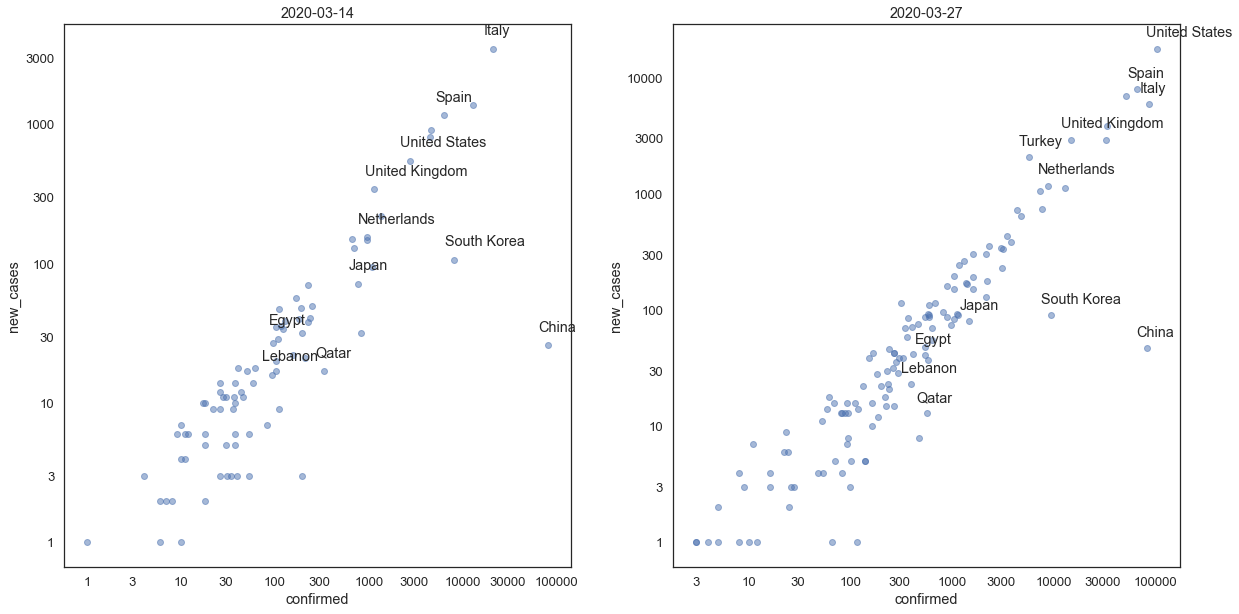

In [665]:
interest_countries = ['United States', 'Italy', 'China', 'Lebanon','Japan','South Korea', 'United Kingdom','Spain','Egypt','Qatar','Netherlands']
interest_countries2 = ['United States', 'Italy', 'China', 'Lebanon','Japan','South Korea', 'United Kingdom','Spain','Egypt','Qatar','Netherlands','Turkey']

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(20)

plt.subplot(121)
plot_on_date('2020-03-14',interest_countries)

plt.subplot(122)
plot_on_date('2020-03-27',interest_countries2)


By comparing the plots, we can see that countries that are doing the worst are all aligned on a line. By comparing the countries on the left (Mar,14) to those on the right (Mar,27), we can predict the countries that are going to do better or worse on the upcoming days. Here are some examples:

- **United States:** In Mar, 14 the United States plot was situated on the 'danger line' like many other countries. In the second plot, we can see how quickly the number of cases increased. Unfortunately, The United States doesn't seem to have dropped from the line in the second plot as well.
- **Italy:** Italy was in the very high right in the first plot. However, in the second plot we can see a noticable improvement.
- **China and South Korea:** They seem to be recovering after a huge battle with the virus.
- **Lebanon:** We can see the position of Lebanon within countries. We can see it performing much better than Egypt but worse than Qatar for example.
- **Turkey:** Turkey was not available in the first plot. But the second plot suggests that it has a huge battle a head.

Comparing countries is good if we know what we are looking for. However, a better way of understanding the virus globally is to check how certain containment measures have affected the spread of the virus. 

One such factor is how long it took the country to start enforcing serious measures such as school and university closure and business suspension. To do that, we need to create some more variables.


In [666]:
# get first case for each country
keywords = ['school closure','closure school','university closure','closure university','business suspension','social distancing']
df2= df.query('date == "2020-03-27"')
test_df = df[df.confirmed >  1].groupby('country',as_index=False).date.min().rename(columns={'date': 'date_first_case'})
test2_df = df[df.keywords.str.contains('|'.join(keywords))].groupby('country',as_index=False).date.min().rename(columns={'date': 'date_first_measure'})
data = pd.merge(test_df,test2_df,how='inner',on='country')
data['delay'] = (data['date_first_measure'] - data['date_first_case']).dt.days
df2= df.query('date == "2020-03-27"')
df3 = pd.merge(data,df2,how='inner',on='country')

Here, we created three variables:
- `date_first_case`: the date of the first confirmed case in a country.
- `date_first_measure`: the date when certain measures were taken (suggested by the `keywords` list).
- `delay`: the difference between the first measure taken and the first case (in days)

The reason for this is that we expect that countries that did not close public establishments quickly after discovering the first case, are going to have a higher chance of spreading the virus.

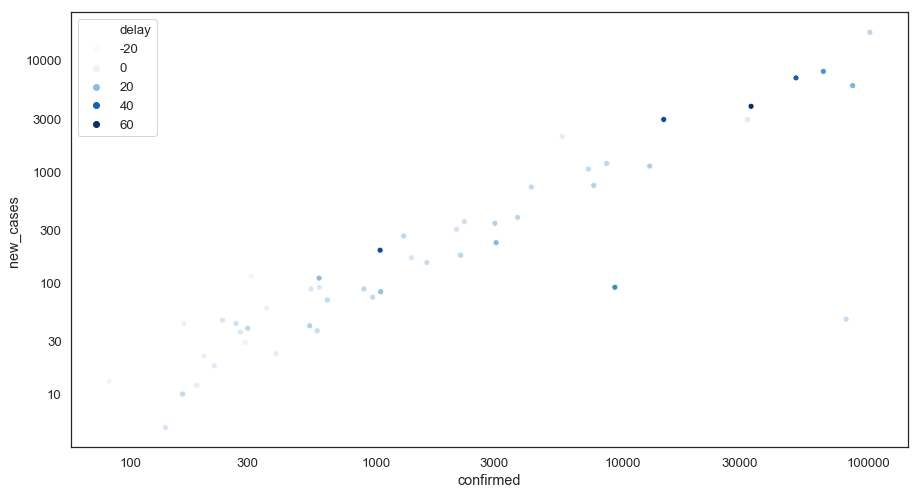

In [667]:
df3 = df3.query('new_cases > 0')
x = np.log10(df3.confirmed)
y = np.log10(df3.new_cases)
z = df3.delay
plt.figure(figsize=(15,8))
xticks = [1,3,10,30,100,300,1000,3000,10000,30000,100000,300000]
plt.xticks(np.log10(xticks),xticks)
yticks =  [1,3,10,30,100,300,1000,3000,10000,30000]
plt.yticks(np.log10(yticks),yticks)
ax = sns.scatterplot(x,y,hue=z,palette='Blues');

The plot above shows that taking certain measures after discovering the first case of Covid-19 really helps in fighting the virus. The delay in applying such measures is an important factor in determining how quickly the virus would spread across the country.

The keywords of interest ('school closure','university closure',etc) represent - in my opinion - the time where a country starts taking more serious measures to contain the virus. Although there are many more. the data that we have is limited and might not be very accurate. 

However, we can clearly see that countries that took more time to start closing public establishment have a much greater spread than others. 

## Conclusion

In this report we took a look at the global spread and containment of the Covid-19 virus. Some of the questions that we were able to answer:

*Q: Which countries are doing better than others and why?*

Many countries were able to reduce the impact of the virus not only by taking suitable measure but also by being able to enforce them quickly after discovering the first case.

*Q: What measures are the most effective against the spread of the virus?*

We have seen that the most common measures taken to limit the spread of the virus include: 'university closure', 'school closure','travel ban'. However, what is more important is being able to enforce them correctly and within time.

*Q: How do the death and recovery rates compare according to population, density and median age of a country?*

In general, countries with high population tend to have a higher number of cases. Median age seem to be weakly correlated with the number of deaths. 

*Q: How does Lebanon compare to other countries regarding measures taken and spread of the virus?*

We saw how Lebanon compared with other countries. It is performing well in general but still has a long battle ahead.

In [671]:
# finally saving
df.to_csv('./datasources/final_dataset.csv',index=False)